## XAFS Data Processing

Here we'll use Larch to replicate the examples from [Bruce Ravell's tutorial](https://www.diamond.ac.uk/Instruments/Spectroscopy/Techniques/XAS.html) at diamond 
for XAFS data processing:

  1. read data from an ascii file
  2. do normalisation
  3. do XAFS background subtraction with autobk()
  4. do XAFS Fourier transform with xfft()
  
For more details, see https://xraypy.github.io/xraylarch/xafs/

We'll start with reading and a raw data file:

## Data Readers
The first example requires loading a dataset and doing some basic analysis.
The available readers are read_ascii(), read_xdi(), and read_gsexdi() for text column files and read_athena() and extract_athenagroup(), for Athena Project files.

In [1]:
from larch.io import read_ascii
# https://vimeo.com/340207346 07:01
fe_xafs = read_ascii('XAFSExamples/Fe_standards/Fe_lepidocrocite.000')
# using vars(fe_data) we see that the object has the following properties: 
# path, filename, header, data, attrs, energy, i0, it, ir, inttime, and labels
# vars(fe_xafs)

In [2]:
# the following prints show the contents of each
print("path:\t\t", fe_xafs.path)
print("filename:\t", fe_xafs.filename)
print(fe_xafs.header)
print(fe_xafs.data)
print(fe_xafs.attrs)
print(fe_xafs.energy)
print(fe_xafs.i0)
print(fe_xafs.it)
print(fe_xafs.inttime)
print(fe_xafs.array_labels)

path:		 XAFSExamples/Fe_standards/Fe_lepidocrocite.000
filename:	 Fe_lepidocrocite.000
['XDAC V1.4 Datafile V1', '"Fe_lepidocrocite.000" created on 11/3/2011 at 1:10:04 PM on X-23A2', 'Diffraction element= Si (311).  Ring energy= 2.80 GeV', 'E0= 7112.00', 'NUM_REGIONS= 4', 'SRB= -200 -20 30 60 15k', 'SRSS= 10 0.25 0.05k 0.05k', 'SPP= 0.5 0.5 0.5 0.125k', 'Settling time= 0.10', 'Offsets= 0.00 37.25 86.25 0.00', 'Gains= 8.00 8.00 9.00 1.00', 'gamma-FeOOH on tape', '--------------------------------------------------------------------------------', 'Energy            I0            It            Ir       IntTime']
[[6.91200137e+03 6.92199811e+03 6.93199952e+03 ... 7.95994966e+03
  7.96564138e+03 7.97135723e+03]
 [5.00400000e+03 5.00600000e+03 5.03100000e+03 ... 1.85870000e+04
  1.86510000e+04 1.87000000e+04]
 [7.26375000e+02 7.34375000e+02 7.45375000e+02 ... 4.70652880e+03
  4.74430530e+03 4.77608180e+03]
 [1.40187500e+03 1.41987500e+03 1.44687500e+03 ... 6.26514380e+03
  6.32662630e+03 6.3

## Calculate and plot $\mu$
Knowing the elements of the input data set it is possible to start manipulating and visualising the XAFS data. 

The following examples show how to calculate $\mu$ and plot it agains the energy.

So far I have not found the larch function for calculating $\mu$, so instead I created a function that calculates $\mu$ and adds it to the group

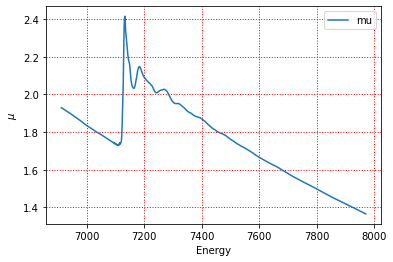

In [8]:
# https://vimeo.com/340207346 15:06
from numpy import log
from larch.utils import group2dict, dict2group

def get_mu(xafs_group):
    # calculate mu
    mu_e = log(abs(xafs_group.i0/xafs_group.it))
    # get a dictionary from te group
    xafs_dict = group2dict(xafs_group)
    # add mu to the dictionary
    xafs_dict['mu'] = mu_e
    xafs_group = dict2group(xafs_dict)
    return xafs_group

fe_xafs = get_mu(fe_xafs)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(fe_xafs.energy, fe_xafs.mu, label='mu')
plt.xlabel('Energy')
plt.ylabel('$\mu$')
plt.legend() # include the leyend in the plot
plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid

After loading athena presents the oscilatory spectrum, the r-space and the q-space. Athena uses several default parameter values. Using those same default values it is possible to try and reproduce the initial results for loading a file, starting with normalisation. 

The default values on athena are shown in the table below.

|Area | Varialbe      | Value    |
|:-----:|:------------- |:--------:|
| Current Group| File | XAFSExamples/Fe_standards/Fe_lepidocrocite.000|
|| Element       |   26 Iron |
|| Edge |   K |
|Background removal and normalisation| E0|7128.74769|
||rbkg|1.0|
||flaten normalised data|true|
||k-weight| 2|
||normalization order|3|
||pre-edge range| \[ -150.00, -30.00\]|
| |Edge step| 0.461424|
| |fix|false
| |normalization range| \[ 150.00, 742.610\]|
| |spline range in k| \[ 0, 14.871\]|
| |spline range in e| \[ 0, 842.5651\]|
| |spline clamps low| none|
| |spline clamps low| strong|
| |standard|none|
|Forward fourier transform|k-range| \[ 3.000, 12.871\]|
| |dk|1|
| |window|Hanning|
| |arbitrary k-weight|0.5|
| |phase correction|false|
|Backward fourier transform|R-range| \[ 1, 3\]|
| |dR|0.0|
| |window|Hanning|
|Plotting|plot multiplier|1|
| |y-axis offset|0|
| |e-min|-200|
| |e-max|800|


## Normalisation 
The pre_edge function performs Pre-edge subtraction and normalization. This performs a number of steps:
 1. determine <it>E</it><sub>0</sub> (if not supplied) from max of deriv(mu)
 2. fit a line of polynomial to the region below the edge
 3. fit a polynomial to the region above the edge
 4. extrapolate the two curves to <it>E</it><sub>0</sub> to determine the edge jump
The group passed as an argument will contain the results of the arguments which are listed in the following table.

|attribute|meaning|
|:----|:----|
|e0|energy origin|
|edge_step|edge step|
|norm|normalized mu(E) (array)|
|flat|flattened, normalized mu(E) (array)|
|pre_edge|pre-edge curve (array)|
|post_edge|post-edge, normalization curve (array)|
|pre_slope|slope of pre-edge line|
|pre_offset|offset of pre-edge line|
|nvict|value of nvict used|
|nnorm|value of nnorm used|
|norm_c0|constant of normalization polynomial|
|norm_c1|linear coefficient of normalization polynomial|
|norm_c2|quadratic coefficient of normalization polynomial|
|norm_c*|higher power coefficients of normalization polynomial|

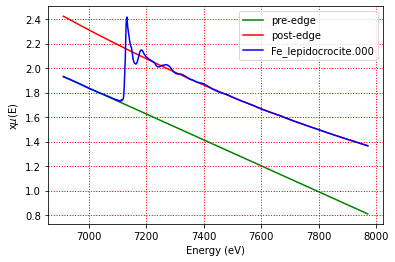

In [5]:
# https://vimeo.com/340207346 25:00
from larch.xafs import pre_edge
#calculate pre-edge and post edge and add them to group
pre_edge(fe_xafs, group=fe_xafs)

plt.plot(fe_xafs.energy, fe_xafs.pre_edge, 'g', label='pre-edge') # plot pre-edge in green
plt.plot(fe_xafs.energy, fe_xafs.post_edge, 'r', label='post-edge')# plot post-edge in green
plt.plot(fe_xafs.energy, fe_xafs.mu, 'b', label=fe_xafs.filename) # plot mu in blue
plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
plt.xlabel('Energy (eV)') # label y graph
plt.ylabel('x$\mu$(E)') # label y axis
plt.legend() # show legend

Normalisation is intednded to take out the effect of thickness and/or amplifier gain which might affect the calculation of $\mu$.

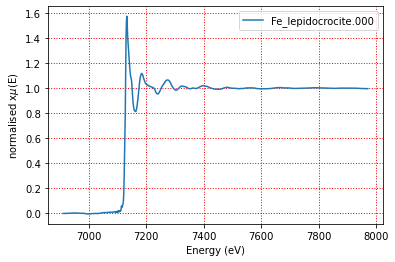

In [6]:
# https://vimeo.com/340207346 25:00
plt.plot(fe_xafs.energy, fe_xafs.flat, label=fe_xafs.filename) # plot flattened and normalised energy
plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
plt.xlabel('Energy (eV)') # label y graph
plt.ylabel(r'normalised x$\mu$(E)') # label y axis
plt.legend() # show legend

In [7]:
# these two lines help when formating subscripta and
# supperscripts for printing
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

print( 'Element Symbol', "\t", fe_xafs.atsym)
print ('Edge',"\t\t", fe_xafs.edge)
print ('E0'.translate(SUB),"\t\t", fe_xafs.e0)
print ('Edge Step',"\t", fe_xafs.edge_step)

Element Symbol 	 Fe
Edge 		 K
E₀ 		 7128.4977
Edge Step 	 0.45692757080772495


## Background and Chi
The function autobk can be used to determine the post-edge background function, $\mu$<sub>0</sub>(E), and corresponding $\chi$<sup>(k)</sup>.

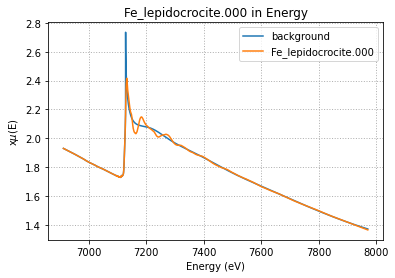

In [27]:
from larch.xafs import autobk
autobk(fe_xafs) # using defaults so no additional parameters are passed
plt.plot(fe_xafs.energy, fe_xafs.bkg, label='background')
plt.plot(fe_xafs.energy, fe_xafs.mu, label=fe_xafs.filename) # plot mu 
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.xlabel(r'Energy (eV)')
plt.ylabel(r'x$\mu$(E)')
plt.title(fe_xafs.filename+" in Energy")
plt.legend()

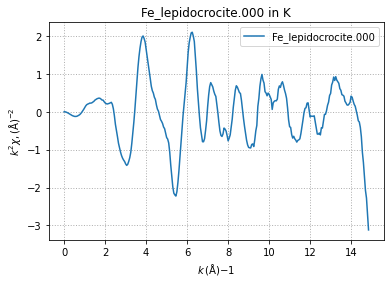

In [30]:
# https://vimeo.com/340207346 36:00
from larch.xafs import autobk
autobk(fe_xafs)
plt.plot(fe_xafs.k, fe_xafs.chi*fe_xafs.k**2, label=fe_xafs.filename)
plt.xlabel(r'$k\, ({\rm\AA}){-1}$')
plt.ylabel(r'$k^2\chi, ({\rm\AA})^{-2}$')
plt.title(fe_xafs.filename+" in K")
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.legend()

A graph similar to the one below is also shown in athena while loading hte data.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(fe_xafs.energy, fe_xafs.mu, label='mu')
plt.xlabel('Energy')
plt.ylabel('mu')
plt.legend()

In [ ]:
from larch.xafs import autobk
autobk(fe_xafs.energy, mu_e, rbkg=1.0, group=fe_xafs)
#vars(fe_xafs)
plt.plot(fe_xafs.k, fe_xafs.chi)
plt.xlabel(r'$k\, ({\rm\AA})^{-1}$')

In [ ]:
from larch.io import read_athena
project = read_athena('../xraylarch/examples/xafsdata/fe_athena.prj')

In [ ]:
for name, group in project._athena_groups.items():
    print(name, group)

Let's get that data group for Fe2O3 and look at what that Group object contains

In [ ]:
fe2o3 = project.fe2o3_rt1_xmu
for attr in dir(fe2o3):
    print(attr, type(getattr(fe2o3, attr)))

There are several components to this Group of data.  We note that there are arrays for `energy` and `mu`.   These are what represent $\mu(E)$.

----------

We'll want to plot this data and the other data arrays as we go. The standard scientific-python-Jupyter approach would be to use inline maplotlib:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(fe2o3.energy, fe2o3.mu, label='mu')
plt.xlabel('Energy')
plt.ylabel('mu')
plt.legend()

As an aside, we could also use the wxmplot plotting tools that were developed for Larch to make equivalent plots.
Instead of being a static plot in-line, this will bring up an external window for the plot.  This external window will be just like that from the XAS Viewer GUI application: zooming is supported and essentially all styling and colors can be changed interactively as well as easy methods for exporting plots.  It turns out that this currently does not with Anaconda Python on MacOSX, so we'll test for that. 

When it does work (Linux, Windows, MacOS other than Anaconda Python) the equivalent plot would be:

In [ ]:
#import os, sys
#if sys.platform == 'darwin' and os.path.exists(os.path.join(sys.prefix, 'conda-meta')):
#    print("wxmplot does not work in Jupyter from Anaconda Python on Mac OS")
#else:
#    from wxmplot.interactive import plot
#    plot(fe2o3.energy, fe2o3.mu, label='mu', xlabel='Energy', ylabel='mu', show_legend=True)

Now let's remove the XAFS background and extract the EXAFS $\chi(k)$.   We'll use
the `autobk()` function (https://xraypy.github.io/xraylarch/xafs/autobk.html)

Note that we pass in the *Group* as the first argument.  The `autobk()` function will add several attributes to this Group -- it will be the container for this dataset.

In [ ]:
from larch.xafs import autobk
autobk(fe2o3, rbkg=0.85, kweight=2)

plt.plot(fe2o3.k, fe2o3.chi)
plt.xlabel(r'$k\, ({\rm\AA})^{-1}$')

but we usually want to plot $k$-weighted $\chi(k)$:

In [ ]:
plt.plot(fe2o3.k, fe2o3.chi*fe2o3.k**2, label='$\chi$')
plt.xlabel(r'$k\, ({\rm\AA}){-1}$')
plt.ylabel(r'$k^2\chi, ({\rm\AA})^{-2}$')
plt.legend()

we'll keep plotting with in-line plots, but to avoid having to type out the full markup for the labels, we'll import them and use them: 

In [ ]:
from larch.wxlib import plotlabels as plab
print(dir(plab))
plt.plot(fe2o3.k, fe2o3.chi*fe2o3.k**2)
plt.xlabel(plab.k)
plt.ylabel(plab.chikw.format(2))

we can also plot the background $\mu_0(E)$:

In [ ]:
plt.plot(fe2o3.energy, fe2o3.mu, label='mu')
plt.plot(fe2o3.energy, fe2o3.bkg, label='bkg')
plt.xlabel(plab.energy)
plt.ylabel(plab.mu)
plt.legend()

and now we will do the Fourier transform from $\chi(k)$ to $\chi(R)$, using the `xftf()` (XAFS Fourier Transform Forward) function.  We'll do the Fourier transform on $k^2$ weighted $\chi(k)$ with a Kaiser-Bessel Window. 

In [ ]:
from larch.xafs import xftf
xftf(fe2o3, kweight=2, kmin=2, kmax=13.0, dk=5, kwindow='Kaiser-Bessel')

In [ ]:
plt.plot(fe2o3.k, fe2o3.chi*fe2o3.k**2, label='chi(k)')
plt.plot(fe2o3.k, fe2o3.kwin, label='window')
plt.xlabel(plab.k)
plt.ylabel(plab.chikw.format(2))
plt.legend()

and we can show that data as $\chi(R)$

In [ ]:
plt.plot(fe2o3.r, fe2o3.chir_mag, label='chi(r), mag')
plt.plot(fe2o3.r, fe2o3.chir_re, label='chi(r), real)')
plt.xlabel(plab.r)
plt.ylabel(plab.chir.format(3))
plt.legend()